In [209]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle


In [247]:
from backtest import DataParser, MovingWindow
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from indicators import ZigZag


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 20
tfdict = {"M5":0, "M15":1, "H1":2}
zz = ZigZag()
Xl, Xs, yl, ys, odates, poslist, targets = [], [], [], [], [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[1:]:
        f, _ = mw(pos.open_indx)
        fo = f.Open[:-2]/f.Open[-2]
        fc = f.Close[:-2]/f.Open[:-2]
        fh = f.High[:-2]/f.Open[:-2]
        fl = f.Low[:-2]/f.Open[:-2]
        fv = f.Volume[:-2]
        odate = pd.to_datetime(pos.open_date)
        odate = odate.year*10000 + odate.month*100 + odate.day
        if pos.dir == 1:
            Xl.append(np.hstack([fc, fo, fl, fh, fv, btest.cfg.stops_processor.func.cfg.sl, btest.cfg.stops_processor.func.cfg.tp, odate, tfdict[btest.cfg.period]]))
            yl.append(pos.profit)
        else:
            Xs.append(np.hstack([2-fc, 2-fo, 2-fl, 2-fh, fv, btest.cfg.stops_processor.func.cfg.sl, btest.cfg.stops_processor.func.cfg.tp, odate, tfdict[btest.cfg.period]])) 
            ys.append(pos.profit) 
        poslist.append(pos)
        targets.append(pos.dir*(hist.Close[pos.open_indx:pos.open_indx+fsize].mean() - hist.Open[pos.open_indx])/hist.Open[pos.open_indx]*100)
        
Xs, Xl = np.array(Xs), np.array(Xl)
ys, yl = np.array(ys), np.array(yl)
odates = np.array(odates)
targets = np.clip(np.array(targets), -3, 3)


# ids2add = np.random.choice(np.arange(Xs.shape[0]), size=Xl.shape[0] - Xs.shape[0])
# Xs = np.vstack([Xs, Xs[ids2add]])
# ys = np.hstack([ys, ys[ids2add]])
X = np.vstack([Xs, Xl])
y = np.hstack([ys, yl])
print(Xs.shape, Xl.shape, X.shape, ys.shape, yl.shape, y.shape)

SBER 355
ROSN 234
LKOH 240
GMKN 244
GAZP 215
SBER 780
ROSN 645
LKOH 635
GMKN 661
GAZP 634
(2218, 104) (2415, 104) (4633, 104) (2218,) (2415,) (4633,)


In [248]:
print(" ".join(map("{:6.4f}".format, X[1000])))

1.0034 0.9996 1.0021 1.0021 0.9998 0.9983 1.0002 0.9974 1.0004 1.0006 0.9991 1.0011 1.0000 1.0002 1.0009 1.0032 0.9983 1.0015 1.0002 0.9998 0.9914 0.9951 0.9946 0.9968 0.9989 0.9987 0.9972 0.9974 0.9948 0.9955 0.9961 0.9948 0.9957 0.9957 0.9963 0.9972 1.0002 0.9985 1.0000 1.0002 1.0043 1.0002 1.0036 1.0024 1.0019 1.0011 1.0024 1.0002 1.0015 1.0006 1.0000 1.0011 1.0024 1.0017 1.0009 1.0034 1.0002 1.0021 1.0006 1.0002 0.9998 0.9989 0.9991 0.9991 0.9994 0.9976 0.9991 0.9970 0.9996 0.9994 0.9987 0.9998 0.9996 0.9996 0.9981 1.0000 0.9976 0.9998 0.9998 0.9991 26326.0000 15390.0000 29410.0000 22526.0000 15903.0000 33828.0000 11675.0000 1726.0000 2049.0000 2072.0000 886.0000 2536.0000 3599.0000 2099.0000 3132.0000 15034.0000 27315.0000 12141.0000 9480.0000 3448.0000 2.0000 100.0000 20140929.0000 1.0000


In [239]:
print(" ".join(map("{:6.4f}".format, targets[:10])))

1.1157 -0.7316 -0.4996 0.4355 0.3155 -0.6548 1.2582 -1.2008 0.1169 3.0000


In [240]:
print(" ".join(map("{:6.4f}".format, y[:10])))

-1.4962 -1.9382 -1.8373 -1.8239 -0.2936 -0.5090 0.0904 -1.4245 -2.0000 -2.0000


3473 1160
000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15: +284.8 ->  +290.2 OK
000 profit H1 : +223.6 ->  +224.6 OK
000 mae_train: 0.69 mae_test: 0.70
3473 1160
001 profit M5 :   +0.0 ->    +0.0 --
001 profit M15: +211.6 ->  +220.3 OK
001 profit H1 : +138.2 ->   +87.3 --
001 mae_train: 0.69 mae_test: 0.71
3473 1160
002 profit M5 :   +0.0 ->    +0.0 --
002 profit M15: +393.0 ->  +404.2 OK
002 profit H1 : +236.3 ->  +193.0 --
002 mae_train: 0.70 mae_test: 0.68
3474 1159
003 profit M5 :   +0.0 ->    +0.0 --
003 profit M15: +253.0 ->  +259.7 OK
003 profit H1 : +100.8 ->   +60.3 --
003 mae_train: 0.69 mae_test: 0.70
3474 1159
004 profit M5 :   +0.0 ->    +0.0 --
004 profit M15: +302.3 ->  +305.8 OK
004 profit H1 : +112.2 ->   +66.7 --
004 mae_train: 0.69 mae_test: 0.70
[  0.         288.93035425 162.24403074]  ->  [  0.         296.02761263 126.37527434]
[        nan  0.02456391 -0.22107905]
mae_train: 0.69 mae_test: 0.70 ration: 1.01
av. profit boost: -0.06377023823538587


/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_10347/2397490907.py:82: RuntimeWarning: invalid value encountered in divide
  print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))


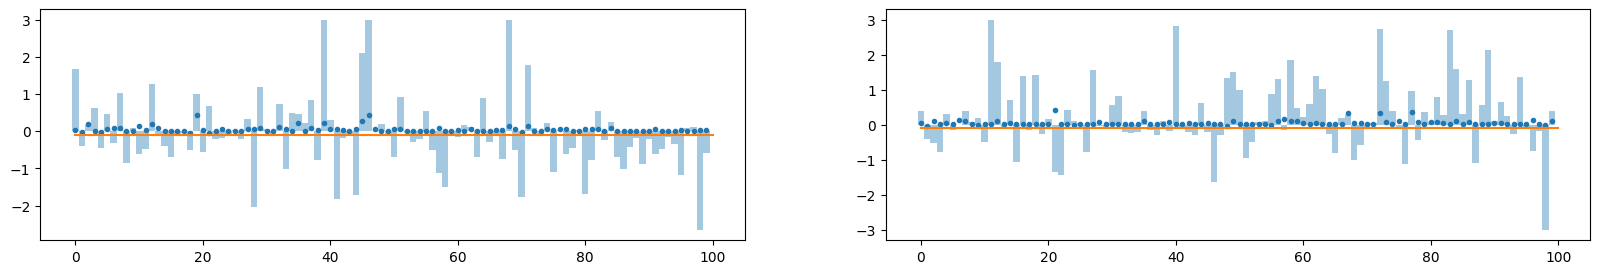

In [249]:
nitrers = 5
test_split = 0.25
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    ids = np.arange(X.shape[0])
    # np.random.shuffle(ids)
    test_size = int(X.shape[0]*test_split)
    ids_test, odates_testset, odates = [], set(), X[:, -2]
    while len(ids_test) < test_size:
        ix = np.random.randint(0, X.shape[0])
        d = odates[ix]
        if d not in odates_testset:
            ii = ids[odates == d]
            ids_test += ii.tolist()
            odates_testset.add(d)
    ids_train = [ix for ix in ids if ix not in ids_test]   
    np.random.shuffle(ids_train) 
    np.random.shuffle(ids_test) 
        
    # ids_test, ids_train = ids[:test_size], ids[test_size:]
    X_train, X_test, y_train, y_test, profs_test = X[ids_train], X[ids_test], targets[ids_train], targets[ids_test], y[ids_test]
    tf_test = X_test[:, -1]
    X_train = X_train[:, :-2]
    X_test = X_test[:, :-2]
    # profs_test = y_test
    # profs_train = y_train
    # y_train = (y_train > 0).astype(int)
    # y_test = (y_test > 0).astype(int)

    # scaler = StandardScaler() 
    # scaler.fit(X_train) 
    # X_train = scaler.transform(X_train) 
    # X_test = scaler.transform(X_test) 
    
    # X_add = X_train + np.random.random(X_train.shape)*0.1
    # X_train = np.vstack([X_train, X_add])
    # y_train = np.hstack([y_train, y_train])
    
    print(X_train.shape[0], X_test.shape[0])
    # evals_result = {}
    # model = lgb.train(params=dict(objective="binary", 
    #                             # metric="auc",
    #                             # num_leaves=2, 
    #                             max_depth=3,
    #                             verbose=-1), 
    #                   train_set=lgb.Dataset(X_train, label=y_train),
    #                   valid_sets=[lgb.Dataset(X_test, label=y_test)],
    #                   num_boost_round=500,
    #                   feval=lgb_f1_score,
    #                   # evals_result=evals_result,
    #                   # verbose_eval=False,
    #                   callbacks=[log_evaluation(-1)]
    #                   )
    # lgb.plot_metric(evals_result, metric='f1')

    model = RandomForestRegressor(max_depth=4, n_estimators=100, min_samples_leaf=3)
    model.fit(X_train, y_train)
    threshold = -0.1
    if len(X_train):
        # p_train = model.predict(X_train)
        p_train = model.predict(X_train)
        # threshold = np.percentile(p_train, 10)
        metrics[0, i] = mean_absolute_error(p_train, y_train)
    # p_test = model.predict(X_test)
    p_test = model.predict(X_test)
    metrics[1, i] = mean_absolute_error(p_test, y_test)

    for j in range(3):
        ids = tf_test == j
        pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
        gprofits[j, i] = profs_test[ids].sum()
        print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    print(f"{i:03} mae_train: {metrics[0, i]:4.2f} mae_test: {metrics[1, i]:4.2f}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)
f1_mean = metrics.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ration: {f1_mean[1]/f1_mean[0]:4.2f}")
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])

004 profit M5 :   +0.0 ->    +0.0 --
004 profit M15: +188.0 ->  +177.7 --
004 profit H1 :  +47.0 ->   +53.8 OK
[  0.         160.75986433  68.13854079]  ->  [  0.         162.53486771  72.02219314]
[       nan 0.01104133 0.05699641]
av. profit boost: 0.024721254472595735


/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_10347/4191841669.py:12: RuntimeWarning: invalid value encountered in divide
  print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))


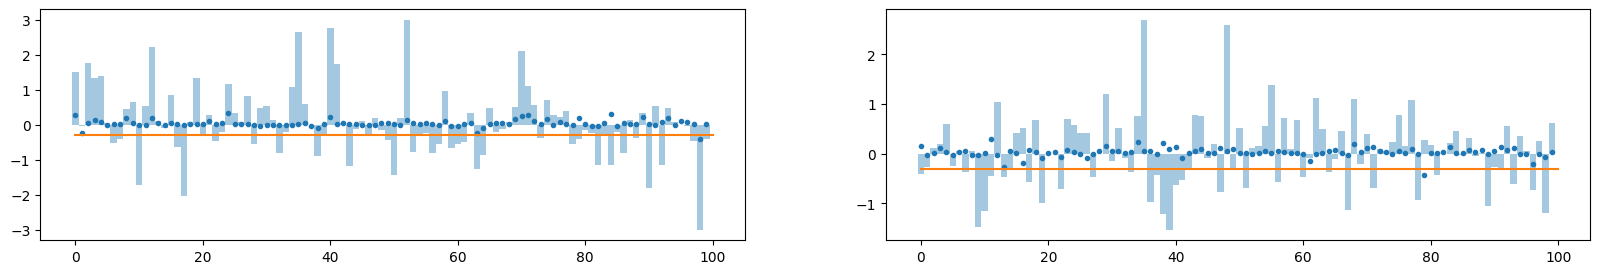

In [244]:
threshold = -0.3
for j in range(3):
    ids = tf_test == j
    pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
    gprofits[j, i] = profs_test[ids].sum()
    print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])

In [33]:
set(X_train[:, -1].astype(int)).intersection(set(X_test[:, -1].astype(int)))

{1, 2, 4}

In [34]:
print(" ".join(map("{:6.4f}".format, model.feature_importances_)))

0.0167 0.0175 0.0179 0.1210 0.1090 0.1112 0.0173 0.0162 0.0163 0.0172 0.0164 0.0164 0.0884 0.0872 0.0938 0.1235 0.1140


In [391]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(1112, 3653, 3682, 3682)

In [ ]:
import mplfinance as mpf

ticker = "GAZP"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="metatrader"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [47]:
prediction

array([[0.49287947, 0.50712053]])